<a href="https://colab.research.google.com/github/Abhyu001/Chest-X-Ray-Classification/blob/main/Chest_X_ray_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
xray_data = pd.read_csv('/kaggle/input/nih-chest-x-ray-14-224x224-resized/Data_Entry_2017.csv')
num_obs = len(xray_data)
print('Number of observations:',num_obs)
xray_data.head()

output: Number of observations: 112120

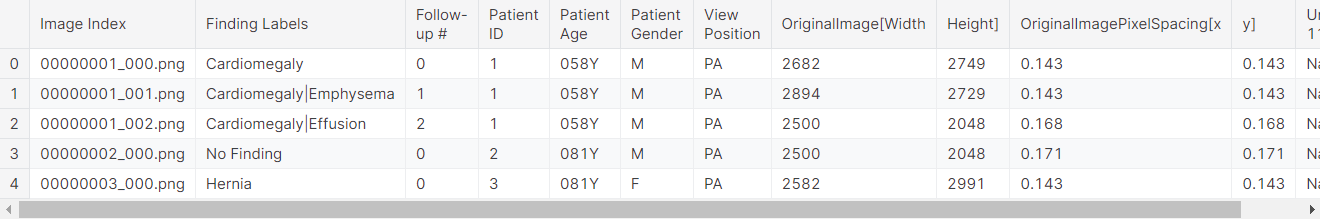

In [ ]:
# Map the image paths onto xray_data
full_img_paths = {os.path.basename(x): x for x in my_glob}
xray_data['full_path'] = xray_data['Image Index'].map(full_img_paths.get)
xray_data.shape

(112120, 13)

In [ ]:
dropLabels = ['Image Index', 'Follow-up #', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11']
xray_data.drop(columns = dropLabels, inplace = True)
xray_data.shape

(112120, 3)

In [ ]:
xray_data.head()

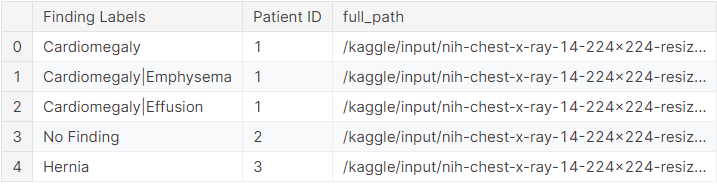

In [ ]:
label_counts = xray_data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

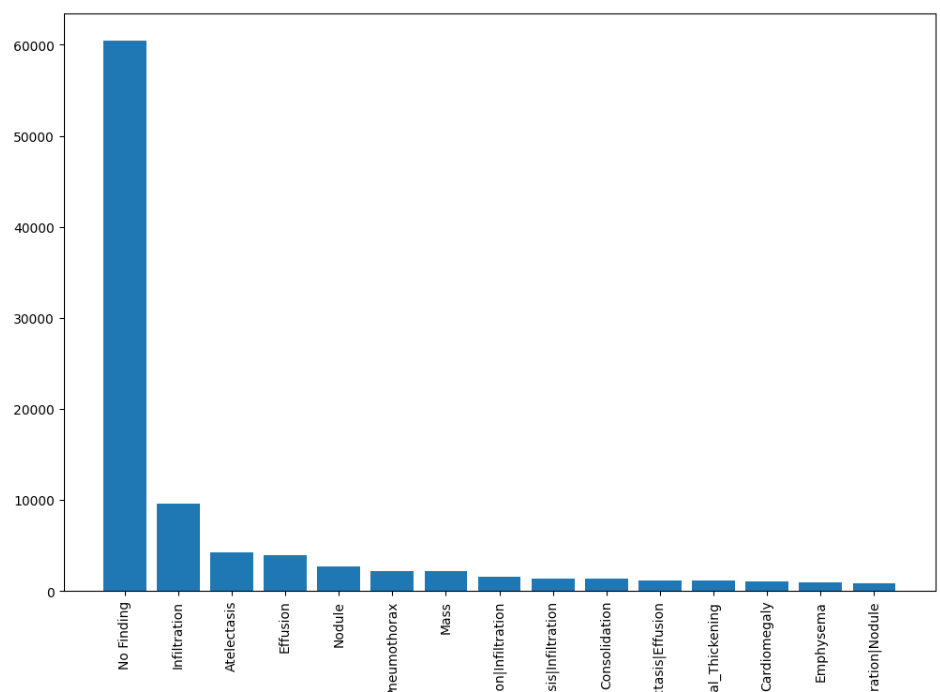

In [ ]:
# keep at least 1000 cases
MIN_CASES = 0
all_labels = [c_label for c_label in all_labels if xray_data[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)),
      [(c_label,int(xray_data[c_label].sum())) for c_label in all_labels])

Clean Labels (14) [('Atelectasis', 11535), ('Cardiomegaly', 2772), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13307), ('Emphysema', 2516), ('Fibrosis', 1686), ('Hernia', 227), ('Infiltration', 19870), ('Mass', 5746), ('Nodule', 6323), ('Pleural_Thickening', 3385), ('Pneumonia', 1353), ('Pneumothorax', 5298)]

In [ ]:
check_for_leakage(train_df, val_df, 'Patient ID')
check_for_leakage(train_df, val_df, 'Patient ID')
check_for_leakage(val_df, test_df, 'Patient ID')

In [ ]:
# print the number of rows in each set
print(f'Train set: {train_df.shape[0]} rows')
print(f'Validation set: {val_df.shape[0]} rows')
print(f'Test set: {test_df.shape[0]} rows')

Train set: 90426 rows
Validation set: 9672 rows
Test set: 12022 rows

In [ ]:
print('Train set:', train_df['Patient ID'].nunique())
print('Validation set:', val_df['Patient ID'].nunique())
print('Test set:', test_df['Patient ID'].nunique())

Train set: 24951
Validation set: 2773
Test set: 3081

In [ ]:
def preprocess_image(img):
    img = img / 255.0
    img = (img - mean) / std
    return img

In [ ]:
train_generator = ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False,
    horizontal_flip=True,
    height_shift_range=0.1,
    width_shift_range=0.05,
    rotation_range=5,
    shear_range=0.1,
    zoom_range=0.05,
    preprocessing_function=preprocess_image
).flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='full_path',
    y_col=labels,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=64
)

Found 90426 validated image filenames.

In [ ]:
val_generator = ImageDataGenerator(
    preprocessing_function=preprocess_image
).flow_from_dataframe(
    dataframe=val_df,
    directory=None,
    x_col='full_path',
    y_col=labels,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=64
)

Found 9672 validated image filenames.

In [ ]:
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0])
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(labels, c_y)
                             if n_score>0.5]))
    c_ax.axis('off')

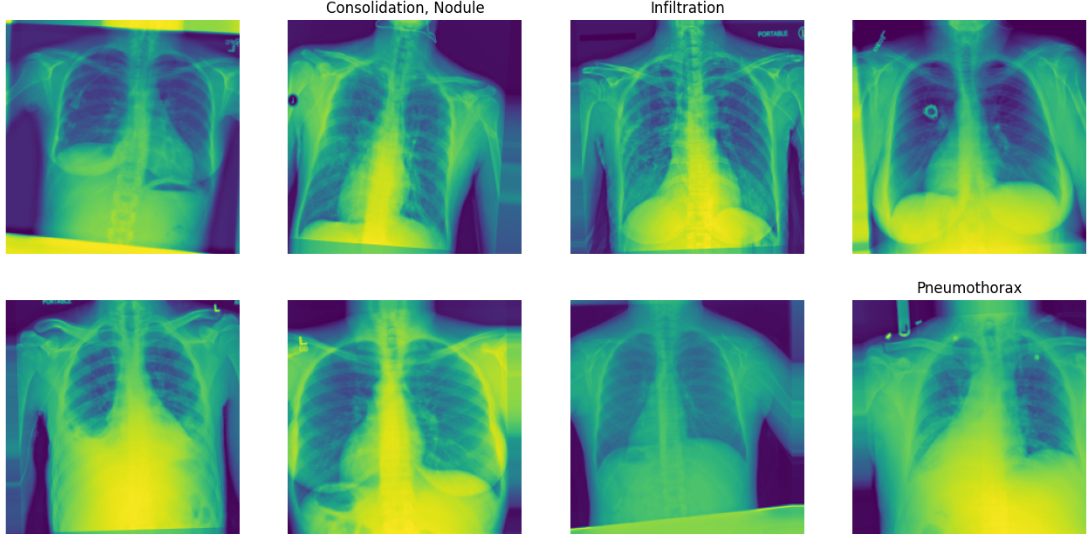

In [ ]:
from keras.applications import EfficientNetV2S

def build_model():
    # Load the pre-trained DenseNet121 model
    base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Add new trainable layers on top of the pre-trained model
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    preds = Dense(len(labels), activation='sigmoid')(x)

    # Create the final model
    model = Model(inputs=inputs, outputs=preds)
    # Create an Adam optimizer with weight decay
    optimizer = AdamW(learning_rate=1e-4)
    model.compile(optimizer=optimizer ,loss='binary_crossentropy',metrics=['binary_accuracy'])
    print(model.summary())
    return model

In [ ]:
import os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

checkpoint_path = 'model/EfficientNetV2S.keras'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Define the ReduceLROnPlateau & ModelCheckpoint & Early stopping callbacks
anne = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_lr=1e-6)
checkpoint = ModelCheckpoint(checkpoint_path, verbose=0, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')

In [ ]:
history = multi_gpu_model.fit(
    train_generator,
    epochs=20,
#     steps_per_epoch=100,
    callbacks=[anne, checkpoint, early_stopping],

    validation_data=val_generator,
)

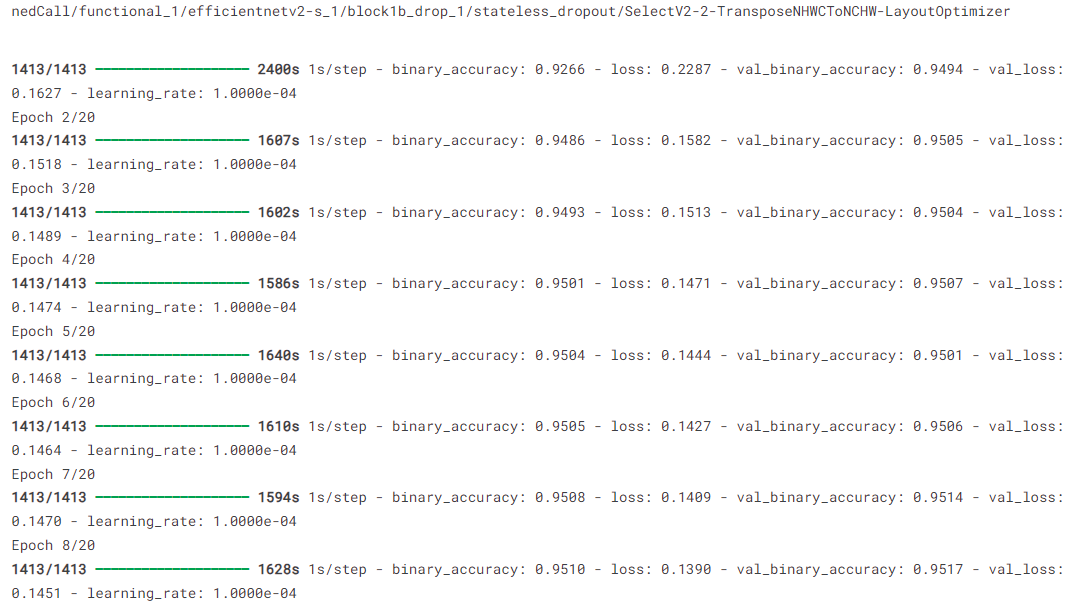

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

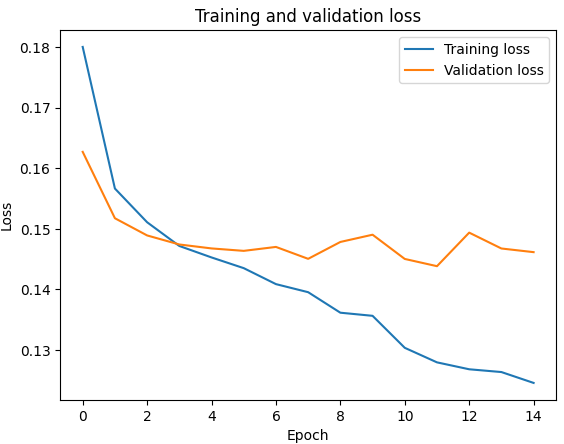